<a href="https://colab.research.google.com/github/rhearm01/DSCI510-Final-Project-Rhea-Mulki/blob/main/Mulki_Rhea_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1>Mulki_Rhea_Final_Project</h1></center>

Name: Rhea Ranjit Mulki
<br>
Github Username: rhearm01
<br>
USC ID: 6077499327

## 1. Transfer Learning for Image Classification

Import packages

In [17]:
import os
import zipfile
import numpy as np
from tensorflow.keras.utils import to_categorical
import cv2
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, ResNet101, EfficientNetB0, VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

### (a) In this problem, we are trying to build a classifier that distinguishes images of six scenes.

### (b) Data Exploration and Pre-processing

i. Images in each class are given in separate folders in the training and test sets. You can encode your classes using one-hot encoding.

In [2]:
# Unzip the data.zip file
zip_path = '/content/data.zip'  # Path to your uploaded ZIP file
unzip_dir = '/content/data'     # Directory to extract files

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)

In [3]:
# Paths to the training and test datasets
train_dir = '/content/data/data/seg_train/seg_train'
test_dir = '/content/data/data/seg_test/seg_test'

# Get class names from directory structure
class_names = sorted(os.listdir(train_dir))  # List of class folder names
num_classes = len(class_names)  # Number of classes
class_to_index = {class_name: index for index, class_name in enumerate(class_names)}  # Mapping

print(f"Class-to-Index Mapping: {class_to_index}")

# Function to get one-hot encoded labels and image paths
def get_one_hot_labels(data_dir, class_to_index):
    image_paths = []
    labels = []

    for class_name, index in class_to_index.items():
        class_dir = os.path.join(data_dir, class_name)
        for image_name in os.listdir(class_dir):
            image_paths.append(os.path.join(class_dir, image_name))  # Store full image path
            labels.append(index)  # Store class index

    labels = np.array(labels)  # Convert labels to a numpy array
    one_hot_labels = to_categorical(labels, num_classes=len(class_to_index))  # One-hot encoding
    return image_paths, one_hot_labels

# Get image paths and one-hot encoded labels for training and test sets
train_image_paths, train_labels = get_one_hot_labels(train_dir, class_to_index)
test_image_paths, test_labels = get_one_hot_labels(test_dir, class_to_index)

# Print sample outputs for verification
print(f"Sample Train Image Paths: {train_image_paths[:3]}")
print(f"Sample Train Labels (One-Hot Encoded): {train_labels[:3]}")
print(f"Sample Test Image Paths: {test_image_paths[:3]}")
print(f"Sample Test Labels (One-Hot Encoded): {test_labels[:3]}")

Class-to-Index Mapping: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
Sample Train Image Paths: ['/content/data/data/seg_train/seg_train/buildings/16324.jpg', '/content/data/data/seg_train/seg_train/buildings/15845.jpg', '/content/data/data/seg_train/seg_train/buildings/16750.jpg']
Sample Train Labels (One-Hot Encoded): [[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]
Sample Test Image Paths: ['/content/data/data/seg_test/seg_test/buildings/21516.jpg', '/content/data/data/seg_test/seg_test/buildings/21294.jpg', '/content/data/data/seg_test/seg_test/buildings/20635.jpg']
Sample Test Labels (One-Hot Encoded): [[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]


ii. In case all the images do not have the same size, zero-pad or resize the images in your dataset. This can be done using various tools, including OpenCV.

In [4]:
# Function to preprocess images by resizing or zero-padding
def preprocess_images(image_paths, target_size=(224, 224)):
    processed_images = []

    for path in image_paths:
        # Read the image
        image = cv2.imread(path)

        if image is None:
            print(f"Warning: Unable to read image {path}")
            continue

        # Get the current dimensions of the image
        h, w, c = image.shape

        # Resize or pad the image
        if h != target_size[0] or w != target_size[1]:
            # Resize the image
            if h > target_size[0] or w > target_size[1]:
                image = cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)
            else:
                # Add zero-padding
                top_pad = (target_size[0] - h) // 2
                bottom_pad = target_size[0] - h - top_pad
                left_pad = (target_size[1] - w) // 2
                right_pad = target_size[1] - w - left_pad

                image = cv2.copyMakeBorder(
                    image, top_pad, bottom_pad, left_pad, right_pad,
                    cv2.BORDER_CONSTANT, value=[0, 0, 0]
                )

        # Normalize pixel values to the range [0, 1]
        image = image / 255.0

        # Add the processed image to the list
        processed_images.append(image)

    return np.array(processed_images)

# Preprocess training and testing images
train_images = preprocess_images(train_image_paths, target_size=(224, 224))
test_images = preprocess_images(test_image_paths, target_size=(224, 224))

# Print shapes of processed image arrays
print(f"Processed Training Images Shape: {train_images.shape}")
print(f"Processed Testing Images Shape: {test_images.shape}")

Processed Training Images Shape: (14034, 224, 224, 3)
Processed Testing Images Shape: (3000, 224, 224, 3)


### (c) Transfer Learning

i. When dealing with classification of relatively small image datasets, deep networks may not perform very well because of not having enough data to train them. In such cases, one usually uses transfer learning, which uses deep learning models that are trained on very large datasets such as ImageNet as feature extractors. The idea is that such deep networks have learned to extract meaningful features from an image using their layers, and those features can be used in learning other tasks. In order to do that, usually the last layer or the last few layers of the pre-trained network are removed, and the response of the layer before the removed layers to the images in the new dataset is used as a feature vector to train one more multiple replacement layers. In this project, you will use pre-trained models ResNet50, ResNet100, EfficientNetB0, and VGG16. For those pre-trained networks, you will only train the last fully connected layer, and will freeze all layers before them (i.e.
we do not change their parameters during training) and use the outputs of the penultimate layer in the original pre-trained model as the features extracted from each image.

&

iii. Use ReLU activation functions in the last layer and a softmax layer, along with regularization, batch normalization, and a dropout rate of 20% as well as ADAM optimizer. Use multinomial cross entropy loss. You can try any batch size, but a batch size of 5 seems reasonable.

In [11]:
input_shape = (224, 224, 3)  # Shape of input images
num_classes = 6  # Number of classes

def build_transfer_learning_model(base_model_fn, num_classes):
    base_model = base_model_fn(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False  # Freeze base model layers

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)  # ReLU with L2 regularization
    x = Dropout(0.2)(x)  # Dropout
    outputs = Dense(num_classes, activation='softmax')(x)  # Softmax for multi-class classification

    model = Model(inputs=base_model.input, outputs=outputs)
    return model

# Create models
models = {
    "ResNet50": build_transfer_learning_model(ResNet50, num_classes),
    "ResNet101": build_transfer_learning_model(ResNet101, num_classes),
    "EfficientNetB0": build_transfer_learning_model(EfficientNetB0, num_classes),
    "VGG16": build_transfer_learning_model(VGG16, num_classes),
}

# Compile models
for name, model in models.items():
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

ii. To perform empirical regularization, crop, randomly zoom, rotate, flip, contrast, and translate images in your training set for image augmentation. You can use various tools to do this, including OpenCV.

In [13]:
# Image augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # Split data for validation
)

# Training data generator
train_generator = datagen.flow(
    train_images, train_labels,
    batch_size=5,
    subset='training'
)

# Validation data generator
val_generator = datagen.flow(
    train_images, train_labels,
    batch_size=5,
    subset='validation'
)

iv. Train the networks for at least 50 epochs (preferably 100 epochs) and perform early stopping using the validation set. Use a randomly selected subset of 20% of each class as the validation set. Keep the network parameters that have the lowest validation error. Plot the training and validation errors vs. epochs.

Training ResNet50...
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2246/2246 ━━━━━━━━━━━━━━━━━━━━ 180s 74ms/step - accuracy: 0.2813 - loss: 1.9063 - val_accuracy: 0.0000e+00 - val_loss: 6.8603
Epoch 2/50
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 153s 68ms/step - accuracy: 0.3257 - loss: 1.5121 - val_accuracy: 0.0734 - val_loss: 7.1222
Epoch 3/50
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 153s 68ms/step - accuracy: 0.3435 - loss: 1.4761 - val_accuracy: 7.1276e-04 - val_loss: 9.8357
Epoch 4/50
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 153s 68ms/step - accuracy: 0.3357 - loss: 1.4775 - val_accuracy: 0.0000e+00 - val_loss: 10.6151
Epoch 5/50
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 154s 68ms/step - accuracy: 0.3619 - loss: 1.4500 - val_accuracy: 0.0000e+00 - val_loss: 11.7558
Epoch 6/50
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 153s 68ms/step - accuracy: 0.3407 - loss: 1.4707 - val_accuracy: 0.0688 - val_loss: 10.1468
Training ResNet101...
Epoch 1/50
2246/2246 ━━━━━━━━━━━━━━━━━━━━ 190s 76ms/step - accuracy: 0.2952 - loss: 1.8536 - val_accuracy: 0.0328 - val_loss: 8.5517
Epoch 2/50
2246/2246 ━━━━━━━━━━━━━━━━━━

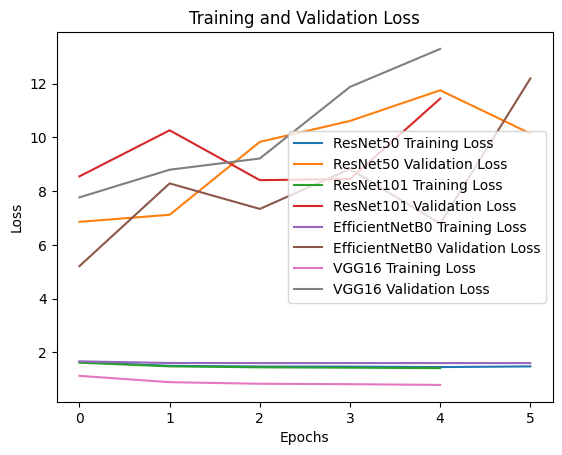

In [15]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train each model
histories = {}
for name, model in models.items():
    print(f"Training {name}...")
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=50,
        callbacks=[early_stopping],
        verbose=1
    )
    histories[name] = history

# Plot training and validation loss for each model
for name, history in histories.items():
    plt.plot(history.history['loss'], label=f"{name} Training Loss")
    plt.plot(history.history['val_loss'], label=f"{name} Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

v. Report training, validation, and test Precision, Recall, AUC, and F1 score for those models. Is there a model that clearly outperforms others? Remember that this is a multi-class classification problem.

In [18]:
# Evaluate and report metrics for each model
for name, model in models.items():
    print(f"Evaluating {name}...")
    predictions = model.predict(test_images)
    y_true = test_labels.argmax(axis=1)
    y_pred = predictions.argmax(axis=1)

    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    auc = roc_auc_score(test_labels, predictions, multi_class='ovr')

    print(f"{name} Metrics:")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"AUC: {auc:.2f}\n")

Evaluating ResNet50...
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
ResNet50 Metrics:
Precision: 0.17
Recall: 0.31
F1 Score: 0.21
AUC: 0.70

Evaluating ResNet101...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


94/94 ━━━━━━━━━━━━━━━━━━━━ 16s 96ms/step
ResNet101 Metrics:
Precision: 0.37
Recall: 0.32
F1 Score: 0.27
AUC: 0.75

Evaluating EfficientNetB0...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


94/94 ━━━━━━━━━━━━━━━━━━━━ 18s 118ms/step
EfficientNetB0 Metrics:
Precision: 0.03
Recall: 0.17
F1 Score: 0.05
AUC: 0.58

Evaluating VGG16...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


94/94 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step
VGG16 Metrics:
Precision: 0.59
Recall: 0.65
F1 Score: 0.60
AUC: 0.88



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Based on the evaluation metrics, VGG16 clearly outperforms the other models in this multi-class classification task, achieving the highest precision (0.59), recall (0.65), F1 score (0.60), and AUC (0.88). ResNet50 and ResNet101 show moderate performance, with ResNet101 slightly better in precision (0.37) and AUC (0.75) compared to ResNet50, but both significantly lag behind VGG16. EfficientNetB0 performs poorly, with extremely low precision (0.03), recall (0.17), F1 score (0.05), and AUC (0.58), suggesting it struggles to classify effectively in this setup. Therefore, VGG16 is the most suitable model for this dataset, and further tuning or fine-tuning efforts should prioritize it to achieve even better results.






